<img src="../img/banner.png" width="500" align="center">

# Procesamiento de lenguaje natural
## Clothing Ecommerce Reviews con Embeddings + LSTM

Preparado por: Alan Churichi

Se utilizará un dataset de reseñas de ropa y su calificacón. Los productos fueron clasificados en un sitio de compras online con puntajes del 1 al 5.

Entrenaremos una red neuronal que, dada una entrada de texto sea capaz de predecír la calificación que se le asignará al producto.

[Link al dataset](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [1]:
%load_ext lab_black

from imblearn.over_sampling import RandomOverSampler
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import gdown
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

plt.style.use("seaborn")

### Datos

In [2]:
# Descargar la carpeta de dataset
dataset_path = "/tf/notebooks/CEIA/nlp/clase-5/data/clothing_ecommerce_reviews.csv"

if os.access(dataset_path, os.F_OK) is False:
    url = "https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP"
    gdown.download(url, dataset_path, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Armar el dataset
df = pd.read_csv(dataset_path, index_col=0)
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating".
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ["Review Text", "Rating"]].dropna()
df_reviews["Rating"] = df_reviews["Rating"] - 1
df_reviews

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4
...,...,...
23481,I was very happy to snag this dress at such a ...,4
23482,"It reminds me of maternity clothes. soft, stre...",2
23483,"This fit well, but the top was very see throug...",2
23484,I bought this dress for a wedding i have this ...,2


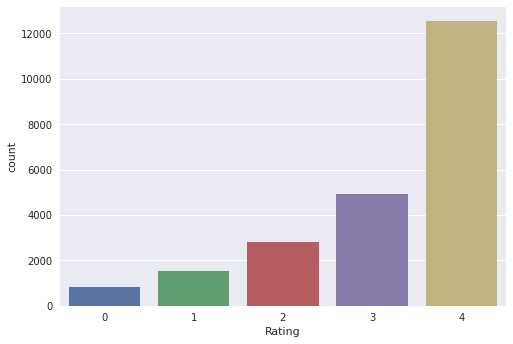

{0: 821, 1: 1549, 2: 2823, 3: 4908, 4: 12540}

In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase

sns.countplot(data=df_reviews, x="Rating")
plt.show()

unique, counts = np.unique(df_reviews["Rating"], return_counts=True)
dict(zip(unique, counts))

Vemos que las clases se encuentran fuertemente desbalanceadas, esto afectará la performance del modelo

In [6]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews = df_reviews["Review Text"].to_numpy()
reviews[:3]

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'],
      dtype=object)

In [7]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

print(f"Hay {reviews.shape[0]} reviews")

Hay 22641 reviews


In [8]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = " ".join(reviews)

In [9]:
# Alumno: ¿Cuál es la longitud de ese corpus?

print(f"El corpus tiene una longitud de {len(corpus)} caracteres")

El corpus tiene una longitud de 7011643 caracteres


In [10]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase

tokens = text_to_word_sequence(corpus)

In [11]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [12]:
# Alumno: ¿Cuántos tokens/palabras hay?

print(f"El corpus tokenizado contiene {len(tokens)} tokens")

El corpus tokenizado contiene 1372203 tokens


In [13]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.

vocab_size = 8000

tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(tokens)

In [14]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tok.word_index

print(
    f"El vocabulario contiene {len(word_index)} palabras. En el entrnamiento se usaran solo las {vocab_size} mas frecuentes."
)

El vocabulario contiene 14847 palabras. En el entrnamiento se usaran solo las 8000 mas frecuentes.


In [15]:
# Alumno: Convertir las palabras/tokens a números

sequences = tok.texts_to_sequences(reviews)
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [16]:
# Alumno: Determinar cual es la oración más larga

max_len = len(max(sequences, key=len))
print(f"La oracion mas larga tiene {max_len} caracteres")

La oracion mas larga tiene 116 caracteres


In [17]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia

X = pad_sequences(sequences, padding="pre", maxlen=max_len)
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   21,
          7,   18,   33, 1713,   99,    2, 1322,    8,  221,    5,    9,
          4,  106,    3,   36,  314,    2,  131, 1243,    2,  429,   41,
         24,   52,    5,  136, 1243,   33,   95,    2,   72,    4,   95,
          3,   38,  501,    2,   21,    1,   86,   11,   31,  416,   39,
          4,   53,  454,    1,  392,   41,  155,   29,    4,  130, 1372,
         11,  438,  439,    6,  772,   95], dtype=int32)

In [18]:
# Alumno: Observar las dimensiones de la variable input

print(f"Tamaño de la matriz de inputs: {X.shape}")

Tamaño de la matriz de inputs: (22641, 116)


In [19]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y"

y = df_reviews["Rating"].to_numpy()

Luego de diversas pruebas se decidió utilizar RandomOverSampler de la librería imblearn para poder balancear las clases, también se probó hacer undersampling y overlsampling con el método SMOTE. sin embargo los mejores resultados se obtuvieron con RandomOverSampler que repite aleatoriamente muestras de las clases minoritarias.

Se hace oversampling para que todas las clases tengan tantas muestras como la mayor.

In [20]:
oversampler = RandomOverSampler(sampling_strategy="all")
X, y = oversampler.fit_resample(X, y)

print(f"Composición del training set: {len(X)}")

Composición del training set: 62700


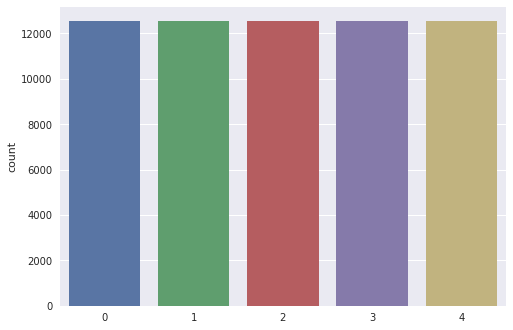

{0: 12540, 1: 12540, 2: 12540, 3: 12540, 4: 12540}

In [21]:
# Distribución de clases con oversampling

sns.countplot(x=y)
plt.show()

unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

In [22]:
# Transformar la variable de salida y mediante oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = to_categorical(y)
print(y.shape)
y[:5]

(62700, 5)


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [23]:
# Alumno: Dividir los datos en train y test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (50160, 116)
y train shape: (50160, 5)
X test shape: (12540, 116)
y test shape: (12540, 5)


In [24]:
# Alumno: determinar la dimensiones de entrada y salida

in_dim = X_train.shape[1]
out_dim = y_train.shape[1]

print(f"Dimension de entrada: {in_dim}")
print(f"Dimension de salida: {out_dim}")

Dimension de entrada: 116
Dimension de salida: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

Se probaron distintas arquitecturas, más y menos complejas. Finalmente se decidió utilizar esta arquitectura simple ya que da una buena performance y el tiempo de entrenamiento requerido por epoch es bajo. Esto nos permite iterar repetidas veces sobre todo el dataset.

In [25]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.

model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=50, input_length=in_dim))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(out_dim, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

2022-08-03 05:05:52.155967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:05:52.174492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:05:52.174821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:05:52.175867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 50)           400050    
                                                                 
 lstm (LSTM)                 (None, 116, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 116, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

Se hace el entrenamiento del modelo durante 100 epochs y se utiliza un 20% de los datos para validación.

In [26]:
hist = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=2048)

Epoch 1/100


2022-08-03 05:05:55.818483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


20/20 [==============================] - 5s 114ms/step - loss: 1.5812 - accuracy: 0.2716 - val_loss: 1.4401 - val_accuracy: 0.3361
Epoch 2/100
20/20 [==============================] - 2s 80ms/step - loss: 1.3371 - accuracy: 0.3698 - val_loss: 1.2093 - val_accuracy: 0.4586
Epoch 3/100
20/20 [==============================] - 2s 79ms/step - loss: 1.1347 - accuracy: 0.4710 - val_loss: 1.0423 - val_accuracy: 0.5355
Epoch 4/100
20/20 [==============================] - 2s 79ms/step - loss: 0.9782 - accuracy: 0.5733 - val_loss: 0.9286 - val_accuracy: 0.6172
Epoch 5/100
20/20 [==============================] - 2s 79ms/step - loss: 0.8487 - accuracy: 0.6512 - val_loss: 0.8287 - val_accuracy: 0.6725
Epoch 6/100
20/20 [==============================] - 2s 79ms/step - loss: 0.7497 - accuracy: 0.7078 - val_loss: 0.7862 - val_accuracy: 0.6882
Epoch 7/100
20/20 [==============================] - 2s 79ms/step - loss: 0.6631 - accuracy: 0.7494 - val_loss: 0.7051 - val_accuracy: 0.7330
Epoch 8/100
20/20

Vemos como varía el accuracy en train y validation a medida que pasan los epochs.

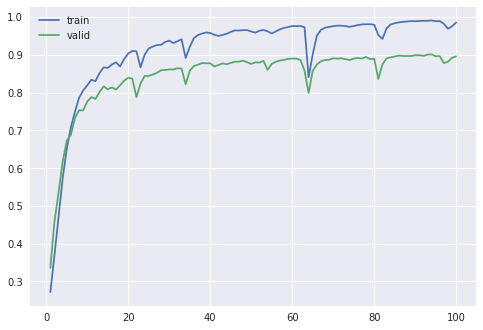

In [27]:
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="train")
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="valid")
plt.show()

Testeamos nuestro modelo con los datos de test.

In [28]:
model.evaluate(X_test, y_test)

392/392 [==============================] - 2s 4ms/step - loss: 0.6460 - accuracy: 0.8976


[0.646003246307373, 0.897607684135437]

Finalmente mostramos algunos ejemplos de los datos de test.

In [29]:
reverse_word_map = {v: k for k, v in word_index.items()}
reverse_word_map[0] = ""


def get_example_from_test(idx):
    review_tokens = [reverse_word_map[word] for word in X_test[idx]]
    review = " ".join(review_tokens).lstrip()
    pred = model.predict(X_test[idx].reshape(1, -1))

    print(f"Review: {review}")
    print(f"\nPred: {np.argmax(pred) + 1}")
    print(f"Truth: {np.argmax(y_test[idx]) + 1}")

In [34]:
get_example_from_test(100)

Review: i saw this tee and was unsure about the print but decided to give it a try i'm glad i did as it has become a weekend staple

Pred: 4
Truth: 4


In [35]:
get_example_from_test(645)

 the colours are true and nice and vibrant definitely size down with this one so so huge it hung so badly of my chest that it looked frumpy and made me look bigger than i am n the small would be giant 

Pred: 2
Truth: 2


In [36]:
get_example_from_test(735)

Review: cute style flowy fabric it runs big i purchased a medium and could've definitely gotten a small

Pred: 4
Truth: 4


In [37]:
get_example_from_test(3)

Review: i ordered the red motif online in my current size 10 the fabric is so beautiful even prettier than the online photo the fit is not great on me it made me look wider at my chest area and almost catches at my hips i'm sure shapewear would take care of this the dress looks really good with a jacket or vest but just weird by itself i agree with the other reviewer who said it was a little short i'm 5'9 it looks good standing up but is very short when i sit there's no real stretch to the

Pred: 3
Truth: 4


Como vemos los resultados son bastante buenos, el accuracy se encuentra en torno al 89%. Lo cual es un valor alto, sobre todo considerando que tenemos 5 posibles resultados. Para comparar la performance de este modelo con otros se podía utilizar el mismo dataset y utilizar BoW o TF-IDF para predecir el Rating de los productos, aunque los resultados dificilmente superen al de este modelo.